<a href="https://colab.research.google.com/github/xue1993/-federated_learning/blob/master/FL_DL_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

1.7.0+cu101 0.8.1+cu101


In [2]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

def get_parameters(net):
    for param in net.parameters():
        print('Summery of parameters:',type(param.data), param.size())
        print('total number of parameters',sum(p.numel() for p in net.parameters() if p.requires_grad))  
        
def mask_grad(original_dy_dx,mask,total_parameters,replace_rate=0.9): 
    
    masked_dy_dx=[]
    
    for i in range(len(original_dy_dx)):
       
        # use your mask to replace values in your input array
        masked_dy_dx.append(original_dy_dx[i].cpu().masked_fill_(mask[i], 0).cuda())
        
    return masked_dy_dx

Extracting /root/.torch/cifar-100-python.tar.gz to /root/.torch
Running on cuda


In [3]:
torch.manual_seed(1234)

In [4]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out
    
net = LeNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [5]:
'''
Summary of the net
'''
print('Summery of net:',net)

for param in net.parameters():
   print('Summery of parameters:',type(param.data), param.size())

total_parameters=sum(p.numel() for p in net.parameters() if p.requires_grad)
print('total number of parameters',total_parameters)  

Summery of net: LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
    (6): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=100, bias=True)
  )
)
Summery of parameters: <class 'torch.Tensor'> torch.Size([12, 3, 5, 5])
Summery of parameters: <class 'torch.Tensor'> torch.Size([12])
Summery of parameters: <class 'torch.Tensor'> torch.Size([12, 12, 5, 5])
Summery of parameters: <class 'torch.Tensor'> torch.Size([12])
Summery of parameters: <class 'torch.Tensor'> torch.Size([12, 12, 5, 5])
Summery of parameters: <class 'torch.Tensor'> torch.Size([12])
Summery of parameters: <class 'torch.Tensor'> torch.Size([12, 12, 5, 5])
Summery 

In [37]:
maxiter=3
method='DLG'



  0%|          | 0/3 [00:00<?, ?it/s]

GT label is 19. 
Onehot label is 19.
Dummy label is 12.
0 1.6999




 33%|███▎      | 1/3 [00:05<00:10,  5.46s/it]

GT label is 8. 
Onehot label is 8.
Dummy label is 64.
0 3.8097




 67%|██████▋   | 2/3 [00:10<00:05,  5.43s/it]

GT label is 26. 
Onehot label is 26.
Dummy label is 40.
0 1.3883




100%|██████████| 3/3 [00:16<00:00,  5.42s/it]


accuracy in label retrieval 1.0
[0.00991366058588028]
[79.36028]


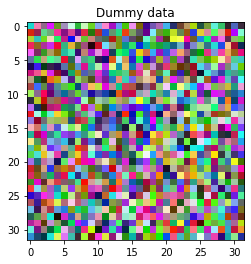

In [39]:
correct_labels=0 #count number of correct labels retrieved

for ii in tqdm(range(maxiter)):
    #initialization
    test_images=[] #store the indexs of images being tested
    MSE_grad=[] #store the MSE of the gradient between true dy/dx and dummy dy/dx
    MSE_image=[] #store the MSE of the true image and dummy image
    history_image=[]

    ######### honest partipant #########
    img_index = np.random.randint(0,50000) #50000 training data of CIFAR-100
    test_images.append(img_index)
    gt_data = tp(dst[img_index][0]).to(device)
    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

    plt.imshow(tt(gt_data[0].cpu()))
    plt.title("Ground truth image")
    print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    # compute original gradient 
    pred = net(gt_data)
    y = criterion(pred, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())


    # share the gradients with other clients
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))


    #create random mask 
    replace_rate=0.99
    mask=[]
    for i in range(len(original_dy_dx)):   
        mask.append(torch.from_numpy(np.random.choice([0, 1], size=original_dy_dx[i].shape, p=((1 - replace_rate), replace_rate)).astype(np.bool)))

    masked_original_dy_dx=mask_grad(original_dy_dx,mask,total_parameters,replace_rate)

    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    
    if method =='DLG':
        dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True) #dummy label is a 1*100 random tensor
        print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
    elif method=='iDLG':
        dummy_label= torch.argmin(torch.sum(masked_original_dy_dx[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False) #tensor of size [1], not require grad
        print("Dummy label is %d." % dummy_label.item())
        optimizer = torch.optim.LBFGS([dummy_data, ]) #dummy_label not updated

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    

    history = []
    for iters in range(10):
        def closure():
            optimizer.zero_grad()

            dummy_pred = net(dummy_data) 
            if method =='DLG':
                dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            elif method=='iDLG':
                dummy_onehot_label = dummy_label          
            dummy_loss = criterion(dummy_pred, dummy_onehot_label) 
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
            dummy_dy_dx=mask_grad(dummy_dy_dx,mask,total_parameters,replace_rate) #apply mask of zeros

            grad_diff = 0
            grad_count = 0
            
                    
            for gx, gy in zip(dummy_dy_dx, masked_original_dy_dx): # TODO: fix the variablas here

                grad_diff += ((gx - gy) ** 2).sum()
                
                grad_count += gx.nelement()

            
            grad_diff = grad_diff / (1-replace_rate) #adjust for the x% uploading
            grad_diff.backward()
            return grad_diff
        
        optimizer.step(closure)

        if iters % 30 == 0: 
            current_loss = closure()
            print(iters, "%.4f" % current_loss.item())

        # early stopping
        if current_loss.item() < 1E-4:
            break
    
    MSE_grad.append(closure().item())
    history_image.append(tt(dummy_data[0].cpu()))
    MSE_image.append(np.linalg.norm(dummy_data[0].detach().cpu().numpy()-gt_data[0].detach().cpu().numpy()))

    if method == 'DLG':
        if (torch.argmax(dummy_label, dim=-1).item()==gt_label.item()):
           correct_labels += 1
    elif method=='iDLG':
        if  dummy_label.item()==gt_label.item():
            correct_labels += 1

print('accuracy in label retrieval',correct_labels/maxiter)
print(MSE_grad)

print(MSE_image)

[46407600.0]


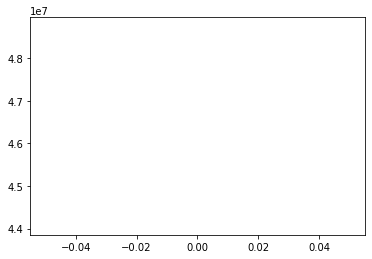

In [29]:
import matplotlib.pyplot as plt
plt.plot(MSE_grad)
print(MSE_grad)